In [1]:
# Core imports 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
# Let's load the data 
# Hard coded Excel path 
# There are three sheets, and we'll load all three 

EXCEL_PATH = os.path.join("info", "2025-26 MTFC Scenario Dataset (updated 9_15_25)_1757954358.xlsx")

# 1) Cause of Loss Smith Co
cause_of_loss_smith_co = pd.read_excel(EXCEL_PATH, sheet_name="Cause of Loss Smith Co").round(2)

# 2) Corn Planting Costs + yearly prices as rows (Year, Category, Value)
cpc = pd.read_excel(EXCEL_PATH, sheet_name="Corn Planting Costs")
cpc_long = cpc.melt(
    id_vars=["Corn following corn"], var_name="Year", value_name="Value"
).rename(columns={"Corn following corn": "Category"})
cpc_long["Year"] = pd.to_numeric(cpc_long["Year"], errors="coerce").astype("Int64")

hp = pd.read_excel(EXCEL_PATH, sheet_name="Corn Harvest Prices")
hp_yearly = hp[["Year", "Avg Cal Yr", "Avg Mktg Yr"]].copy()
hp_long = hp_yearly.melt(id_vars=["Year"], var_name="Category", value_name="Value")

hp_long["Category"] = hp_long["Category"].map({
    "Avg Cal Yr": "Avg Price per Bushel Calendar Year",
    "Avg Mktg Yr": "Avg Price per Bushel Marketing Year"
})

corn_planting_cost_avg_price = (
    pd.concat([cpc_long, hp_long], ignore_index=True)
      .assign(Value=lambda d: pd.to_numeric(d["Value"], errors="coerce"))
      .round(2)
)

# 3) Corn Harvest Prices monthly (Year, Month, Corn Harvest Price per Bushel)
month_cols = [m for m in ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"] if m in hp.columns]
corn_harvest_prices_monthly = (
    hp.melt(id_vars=["Year"], value_vars=month_cols,
            var_name="Month", value_name="Corn Harvest Price per Bushel")
      .dropna(subset=["Corn Harvest Price per Bushel"])
      .assign(
          Year=lambda d: pd.to_numeric(d["Year"], errors="coerce").astype("Int64"),
          **{"Corn Harvest Price per Bushel": lambda d: pd.to_numeric(d["Corn Harvest Price per Bushel"], errors="coerce")}
      )
      .round(2)
)

display(cause_of_loss_smith_co)
display(corn_planting_cost_avg_price[corn_planting_cost_avg_price["Year"] == 2016])
display(corn_harvest_prices_monthly)

,Year,Commodity Name,Insurance Plan Name Abbreviation,Stage Code,Cause of Loss,Month of Loss,# of Policies Paid Out,Avg premium per policy,Avg amout paid out per policy
0,2024,Corn,RP,Replanted,Hail,JUN,1,1823,2774
1,2024,Corn,RP,Reduced Prevented Planting,Excess Moisture/Precipitation/Rain,MAY,1,477,6324
2,2024,Corn,RP,Replanted,Excess Moisture/Precipitation/Rain,MAY,11,3155.727273,2459.454545
3,2024,Corn,RP,Replanted,Excess Moisture/Precipitation/Rain,APR,3,3964,3210
4,2024,Corn,RP,Replanted,Cold Wet Weather,MAY,2,1714.5,978.5
...,...,...,...,...,...,...,...,...,...
1181,1994,Corn,NaN,Replanted,"Other (Volcano,Snow,Lightning,etc)",APR,1,109.6,364
1182,1994,Corn,NaN,Replanted,"Other (Volcano,Snow,Lightning,etc)",MAY,2,71.8,67.2
1183,1994,Corn,NaN,Not Replanted,"Other (Volcano,Snow,Lightning,etc)",APR,0,?,?
1184,1994,Corn,NaN,Not Replanted,"Other (Volcano,Snow,Lightning,etc)",JUN,0,?,?


,Category,Year,Value
0,Machinery costs per acre,2016,129.92
1,"Seed, chemicals, etc. per acre",2016,330.55
2,Labor costs per acre,2016,37.05
3,Assumed yield (bushels/acre),2016,165.00
40,Avg Price per Bushel Calendar Year,2016,3.40
50,Avg Price per Bushel Marketing Year,2016,3.30


,Year,Month,Corn Harvest Price per Bushel
0,2016,Jan,3.55
1,2017,Jan,3.34
2,2018,Jan,3.24
3,2019,Jan,3.52
4,2020,Jan,3.78
...,...,...,...
114,2020,Dec,4.05
115,2021,Dec,5.54
116,2022,Dec,6.69
117,2023,Dec,4.89


In [3]:
# Read the data and then let's see if we can do some simply "querying"

# 1) Cause of Loss: filter by attributes, show all columns
def view_cause_of_loss_metrics(
    year=None,
    commodity=None,
    plan_abbr=None,
    stage_code=None,
    cause_of_loss=None,
    month_of_loss=None,
):
    df = cause_of_loss_smith_co.copy()
    mask = pd.Series(True, index=df.index)
    criteria = {
        "Year": year,
        "Commodity Name": commodity,
        "Insurance Plan Name Abbreviation": plan_abbr,
        "Stage Code": stage_code,
        "Cause of Loss": cause_of_loss,
        "Month of Loss": month_of_loss,
    }
    for c, v in criteria.items():
        if v is not None:
            mask &= df[c] == v
    return df.loc[mask]

# 2) Corn planting costs: all data for a given year
def view_planting_costs_by_year(year):
    df = corn_planting_cost_avg_price
    return df[df["Year"] == int(year)]

# 3) Corn harvest prices: filter by month/year, show all columns
_MONTH_MAP = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sept",10:"Oct",11:"Nov",12:"Dec"}
def view_prices(month=None, year=None):
    df = corn_harvest_prices_monthly.copy()
    if month is not None:
        if isinstance(month, int):
            month = _MONTH_MAP.get(month)
        df = df[df["Month"] == month]
    if year is not None:
        df = df[df["Year"] == int(year)]
    return df

# Some queries just to play with the data:
# display(view_cause_of_loss_metrics(year=2024, commodity="Corn", plan_abbr="RP"))
# display(view_cause_of_loss_metrics(year=2023))
# display(view_planting_costs_by_year(2019))
display(view_prices(month="Apr", year=2021))
display(view_prices(month="Apr"))

,Year,Month,Corn Harvest Price per Bushel
35,2021,Apr,5.35


,Year,Month,Corn Harvest Price per Bushel
30,2016,Apr,3.52
31,2017,Apr,3.34
32,2018,Apr,3.52
33,2019,Apr,3.51
34,2020,Apr,3.28
35,2021,Apr,5.35
36,2022,Apr,7.12
37,2023,Apr,6.75
38,2024,Apr,4.50
39,2025,Apr,4.64


In [4]:
# Question #5: PLANTING COSTS FOR FARMER JONES
# What is the average total cost per acre for corn production (2016-2025) and average total cost per bushel (2016-2025)?

# Select planting cost categories and yield
cost_cats = [
    "Machinery costs per acre",
    "Seed, chemicals, etc. per acre",
    "Labor costs per acre",
]
yield_cat = "Assumed yield (bushels/acre)"

df = corn_planting_cost_avg_price[
    corn_planting_cost_avg_price["Category"].isin(cost_cats + [yield_cat])
]

# Wide table by Year
wide = (
    df.pivot(index="Year", columns="Category", values="Value")
      .apply(pd.to_numeric, errors="coerce")
      .reindex(range(2016, 2026))
)

# Per-year metrics
wide["total_cost_per_acre"] = wide[cost_cats].sum(axis=1)
wide["cost_per_bushel"] = wide["total_cost_per_acre"] / wide[yield_cat]
per_year = wide[["total_cost_per_acre", "cost_per_bushel"]].round(2)

# Averages across 2016–2025
avg_total_cost_per_acre = per_year.loc[2016:2025, "total_cost_per_acre"].mean().round(2)
avg_cost_per_bushel = per_year.loc[2016:2025, "cost_per_bushel"].mean().round(2)

display(per_year)
print("2016–2025 average total cost per acre:", float(avg_total_cost_per_acre))
print("2016–2025 average cost per bushel:", float(avg_cost_per_bushel))

Category,total_cost_per_acre,cost_per_bushel
Year,,
2016,497.52,3.02
2017,443.42,2.69
2018,451.81,2.74
2019,487.98,2.68
2020,469.55,2.58
2021,481.27,2.62
2022,609.71,3.39
2023,732.38,3.96
2024,666.73,3.60


2016–2025 average total cost per acre: 548.11
2016–2025 average cost per bushel: 3.06


In [5]:
#Question 6: ASSUMED YIELD FOR FARMER JONES
# What is the average assumed yield (bushels per acre) for 2016-2025?
avg_yield = (
    corn_planting_cost_avg_price[
        corn_planting_cost_avg_price["Category"] == "Assumed yield (bushels/acre)"
    ]
    .query("2016 <= Year <= 2025")["Value"]
    .mean()
    .round(2)
)

print("Average assumed yield (bushels per acre, 2016–2025):", float(avg_yield))

Average assumed yield (bushels per acre, 2016–2025): 178.5


In [6]:
#7: ANTICIPATED TOTAL PLANTING COSTS
# For Farmer Jones, if all 345 of her farm’s acres are planted, using the average cost per acre found above in #5, what is the anticipated total cost for planting in the next season?

farm_acres = 345
anticipated_total_cost = avg_total_cost_per_acre * farm_acres

print(f"Anticipated total planting cost for {farm_acres} acres: ${anticipated_total_cost:,.2f}")

Anticipated total planting cost for 345 acres: $189,097.95


In [7]:
# Question #8: RANGE FOR ANTICIPATED COSTS
# Critical Thinking: Realistically, is this value found in #7 higher, lower, or “about right” for the actual
# anticipated costs? What might be a realistic “range” (i.e., reasonable minimum and maximum values for the
# planting costs)? Why? Explain in 1-2 sentences (additional computations are optional).


# Yearly total costs per acre, lowest, highest, and range
cost_cats = [
    "Machinery costs per acre",
    "Seed, chemicals, etc. per acre",
    "Labor costs per acre",
]

df = corn_planting_cost_avg_price[
    corn_planting_cost_avg_price["Category"].isin(cost_cats)
].pivot(index="Year", columns="Category", values="Value")

df["Total Cost per Acre"] = df.sum(axis=1)
yearly_stats = df["Total Cost per Acre"].describe()[["min", "max"]].round(2)
cost_range = (yearly_stats["max"] - yearly_stats["min"]).round(2)

# Worst-case scenario (max value of each underlying cost)
worst_case_cost = df[cost_cats].max().sum().round(2)

# Compare 2023 vs 2025
cost_2023 = df.loc[2023, "Total Cost per Acre"]
cost_2025 = df.loc[2025, "Total Cost per Acre"]

print("Yearly total cost per acre (2016–2025):")
display(df[["Total Cost per Acre"]])
print(f"Lowest: ${yearly_stats['min']}, Highest: ${yearly_stats['max']}, Range: ${cost_range}")
print(f"Worst-case scenario total cost per acre: ${worst_case_cost}")
print(f"2023 cost per acre: ${cost_2023}, 2025 cost per acre: ${cost_2025}")

Yearly total cost per acre (2016–2025):


Category,Total Cost per Acre
Year,
2016,497.52
2017,443.42
2018,451.81
2019,487.98
2020,469.55
2021,481.27
2022,609.71
2023,732.38
2024,666.73


Lowest: $443.42, Highest: $732.38, Range: $288.96
Worst-case scenario total cost per acre: $738.4
2023 cost per acre: $732.38, 2025 cost per acre: $640.75


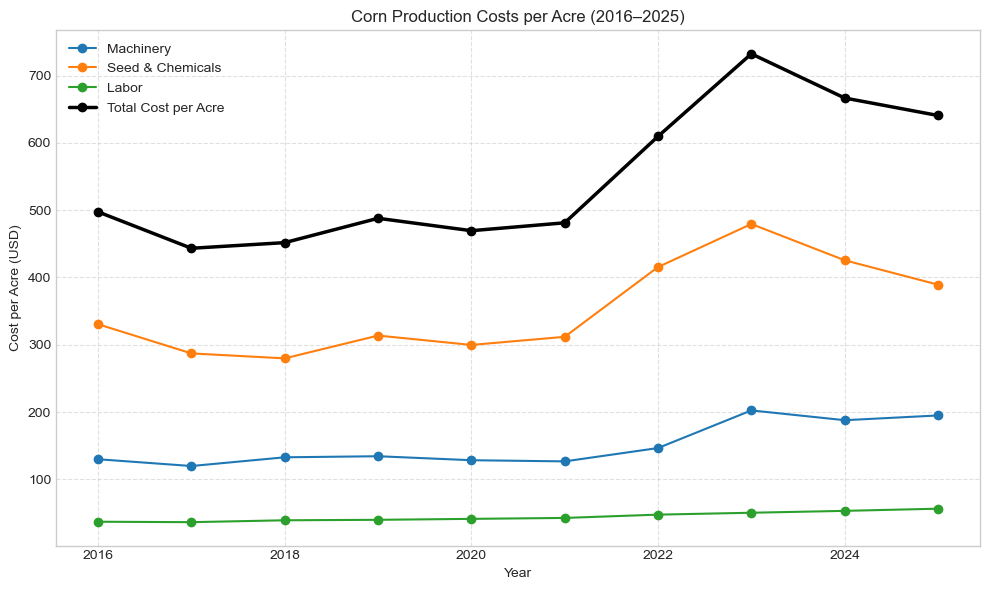

In [8]:
# Q8 continued; let's plot the data


cost_cats = [
    "Machinery costs per acre",
    "Seed, chemicals, etc. per acre",
    "Labor costs per acre",
]

df = corn_planting_cost_avg_price[
    corn_planting_cost_avg_price["Category"].isin(cost_cats)
].pivot(index="Year", columns="Category", values="Value")

df["Total Cost per Acre"] = df.sum(axis=1)

plt.figure(figsize=(10,6))
plt.plot(df.index, df["Machinery costs per acre"], marker="o", label="Machinery")
plt.plot(df.index, df["Seed, chemicals, etc. per acre"], marker="o", label="Seed & Chemicals")
plt.plot(df.index, df["Labor costs per acre"], marker="o", label="Labor")
plt.plot(df.index, df["Total Cost per Acre"], marker="o", linewidth=2.5, color="black", label="Total Cost per Acre")

plt.title("Corn Production Costs per Acre (2016–2025)")
plt.xlabel("Year")
plt.ylabel("Cost per Acre (USD)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Question #9: HARVEST EXPECTATIONS FOR FARMER JONES
# For Farmer Jones, if all 345 acres of her farm are harvested with the average yield found above in #6, what
# is the projected total yield (in bushels)?

projected_total_yield = avg_yield * farm_acres
print(f"Projected total yield for {farm_acres} acres: {projected_total_yield:,.2f} bushels")

Projected total yield for 345 acres: 61,582.50 bushels


Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sept,Oct,Nov,Dec
Avg Price per Bushel ($),4.35,4.43,4.47,4.55,4.65,4.73,4.66,4.46,4.34,4.21,4.2,4.35


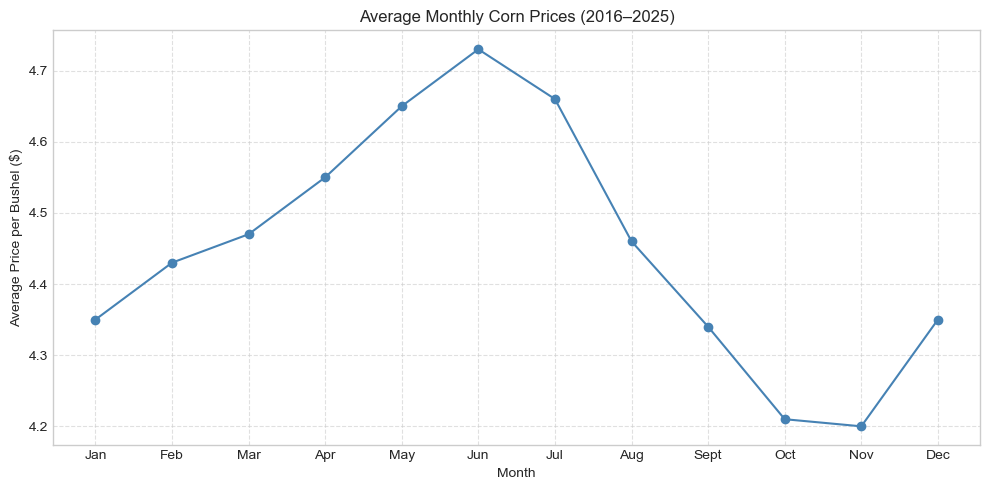

In [10]:
# Question #10: CORN SALE PRICES EXPECTATIONS
# Find the average cash corn prices for each individual month (Jan - Dec) for 2016-2025 and note them in a table

# Filter valid range
df = corn_harvest_prices_monthly.query("2016 <= Year <= 2025").copy()

# Calculate average per month
avg_prices_by_month = (
    df.groupby("Month")["Corn Harvest Price per Bushel"]
      .mean()
      .reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"])
      .round(2)
)

# Display as horizontal table (2 rows x 12 columns)
avg_prices_table = pd.DataFrame([avg_prices_by_month.values],
    columns=avg_prices_by_month.index, index=["Avg Price per Bushel ($)"]
)
display(avg_prices_table)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(avg_prices_by_month.index, avg_prices_by_month.values, marker="o", color="steelblue")
plt.title("Average Monthly Corn Prices (2016–2025)")
plt.xlabel("Month")
plt.ylabel("Average Price per Bushel ($)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [11]:
# Q11 - explain the graph above
# Identify 2-3 trend(s) that you notice regarding cash corn prices (i.e., over the years, within a calendar year, or
# within a marketing year) in the Corn Harvest Prices tab that may impact when a farmer wishes to sell their
# crop. Explain why you believe the trend is noteworthy or why it occurs in 1-2 sentences each (no new computations required).

# This is a very interesting graph that seems to show a strong seasonality component. Average prices in December are close to average prices in January. The prices go up from about October/November, peak in June and then start to come down back till October. This seems to follow the marketing year - if marketing starts in September, it’s probably reasonable to assume that sales are starting in October. 

# This might also have a supply correlation - during the Fall harvest, there might be a lot of supply, and it starts to decrease into the year and as summer approaches, thus leading to price increases.


In [12]:
# Question #12: HARVEST EXPECTATIONS WITH OCTOBER SALE
# If Farmer Jones harvests and sells her entire harvest (found in #9) using the 2016-2025 average corn sale
# price for October (as found above in #10), what would her revenue be? What would her profit be (using
# planting costs found in #7)?

avg_october_price = avg_prices_by_month.loc["Oct"]
revenue = projected_total_yield * avg_october_price
profit = revenue - anticipated_total_cost
print(f"Revenue from selling {projected_total_yield:,.2f} bushels at ${avg_october_price} per bushel: ${revenue:,.2f}")
print(f"Profit after planting costs of ${anticipated_total_cost:,.2f}: ${profit:,.2f}")


Revenue from selling 61,582.50 bushels at $4.21 per bushel: $259,262.33
Profit after planting costs of $189,097.95: $70,164.38


In [13]:
# Question #13: HARVEST EXPECTATIONS WITH OPTIMAL SALE
# If Farmer Jones is able to store her harvested corn and wait for the optimal sale, (using the 2016-2025
# averages found in #10), what could she anticipate for a maximum revenue? Identify the month and revenue amount.

max_price_month = avg_prices_by_month.idxmax()
max_price_value = avg_prices_by_month.max()
max_revenue = projected_total_yield * max_price_value
print(f"Optimal sale month: {max_price_month} at ${max_price_value} per bushel")
print(f"Maximum revenue from selling {projected_total_yield:,.2f} bushels: ${max_revenue:,.2f}")

Optimal sale month: Jun at $4.73 per bushel
Maximum revenue from selling 61,582.50 bushels: $291,285.23


,Total Policies Paid Out,Cumulative %
Cause of Loss,,
Drought,2781,38.16
Decline in Price,2233,68.81
Excess Moisture/Precipitation/Rain,972,82.15
Hail,413,87.81
Flood,180,90.28


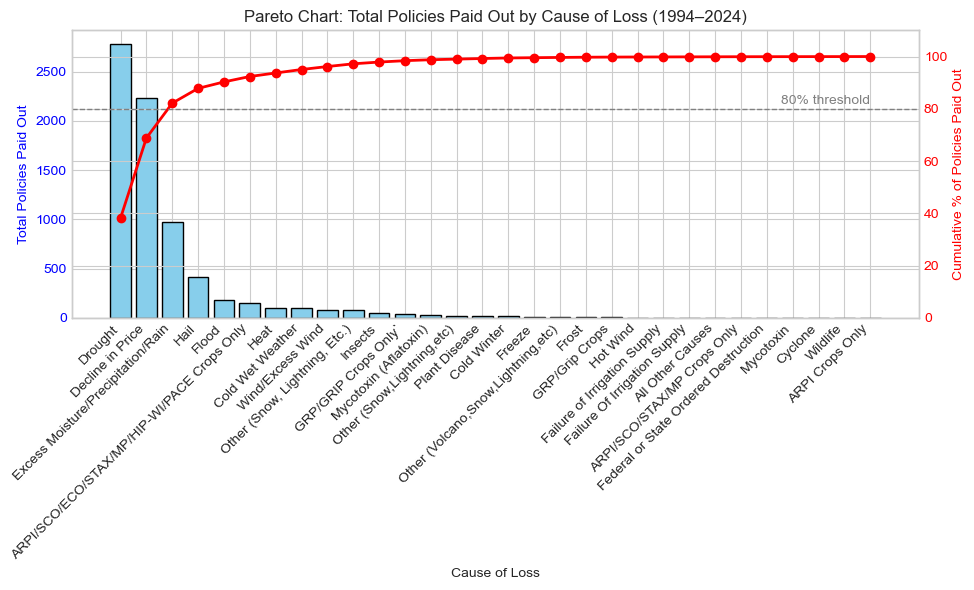

In [14]:
# Question #14: CREATION OF A DATA VISUAL.
# Create a chart (e.g., pie chart, bar chart, etc.) that summarizes, labels, and categorizes the causes of loss for
# claims for 1994-2024. Include the chart in your response.

# Pareto chart + top 5 summary table for Total Policies Paid Out by Cause of Loss (1994–2024)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import StrMethodFormatter

# Aggregate total policies paid out by cause
loss_summary = (
    cause_of_loss_smith_co.groupby("Cause of Loss")["# of Policies Paid Out"]
    .sum()
    .sort_values(ascending=False)
)

# Compute cumulative percentage
cum_pct = 100 * loss_summary.cumsum() / loss_summary.sum()

# Create top 5 table
top5 = pd.DataFrame({
    "Total Policies Paid Out": loss_summary.head(5).astype(int),
    "Cumulative %": cum_pct.head(5).round(2)
})
display(top5)

# Plot Pareto chart
fig, ax1 = plt.subplots(figsize=(10,6))

# Bar plot for frequencies
ax1.bar(loss_summary.index, loss_summary.values, color="skyblue", edgecolor="black")
ax1.set_xlabel("Cause of Loss")
ax1.set_ylabel("Total Policies Paid Out", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
plt.xticks(rotation=45, ha="right")

# Secondary axis for cumulative percentage
ax2 = ax1.twinx()
ax2.plot(loss_summary.index, cum_pct, color="red", marker="o", linewidth=2)
ax2.set_ylabel("Cumulative % of Policies Paid Out", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0, 110)

# Highlight 80% threshold line
ax2.axhline(80, color="gray", linestyle="--", linewidth=1)
ax2.text(len(loss_summary) - 1, 82, "80% threshold", color="gray", ha="right")

plt.title("Pareto Chart: Total Policies Paid Out by Cause of Loss (1994–2024)")
plt.tight_layout()
plt.show()

,Total $ Paid Out,Cumulative %
Cause of Loss,,
Drought,"$73,450,901",58.21
Decline in Price,"$24,316,234",77.48
Excess Moisture/Precipitation/Rain,"$9,059,943",84.66
Hail,"$5,555,844",89.07
ARPI/SCO/ECO/STAX/MP/HIP-WI/PACE Crops Only,"$4,246,479",92.43


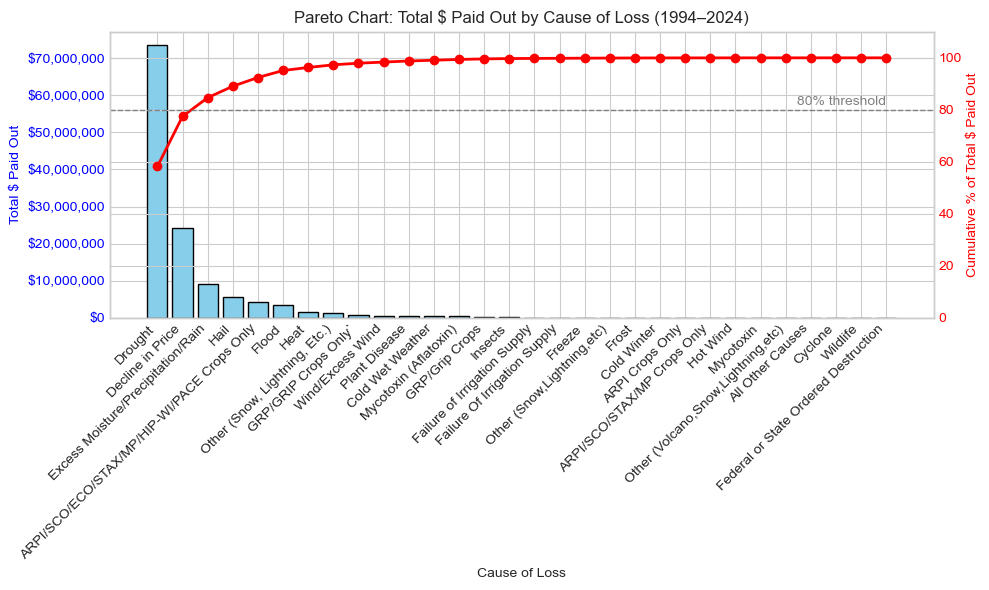

In [15]:
# Continued, this time with Total $ Paid Out

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import StrMethodFormatter

# Prepare data
df = cause_of_loss_smith_co.copy()
df["# of Policies Paid Out"] = pd.to_numeric(df["# of Policies Paid Out"], errors="coerce").fillna(0)
df["Avg amout paid out per policy"] = pd.to_numeric(df["Avg amout paid out per policy"], errors="coerce").fillna(0)
df["Total Paid Out"] = df["# of Policies Paid Out"] * df["Avg amout paid out per policy"]

# Aggregate and sort
loss_summary = (
    df.groupby("Cause of Loss")["Total Paid Out"]
    .sum()
    .sort_values(ascending=False)
)
cum_pct = 100 * loss_summary.cumsum() / loss_summary.sum()

# Create top 5 table
top5 = pd.DataFrame({
    "Total $ Paid Out": loss_summary.head(5).round(2),
    "Cumulative %": cum_pct.head(5).round(2)
})
top5["Total $ Paid Out"] = top5["Total $ Paid Out"].map('${:,.0f}'.format)
display(top5)

# Plot Pareto chart
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.bar(loss_summary.index, loss_summary.values, color="skyblue", edgecolor="black")
ax1.set_xlabel("Cause of Loss")
ax1.set_ylabel("Total $ Paid Out", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.xticks(rotation=45, ha="right")

ax2 = ax1.twinx()
ax2.plot(loss_summary.index, cum_pct, color="red", marker="o", linewidth=2)
ax2.set_ylabel("Cumulative % of Total $ Paid Out", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0, 110)
ax2.axhline(80, color="gray", linestyle="--", linewidth=1)
ax2.text(len(loss_summary)-1, 82, "80% threshold", color="gray", ha="right")

plt.title("Pareto Chart: Total $ Paid Out by Cause of Loss (1994–2024)")
plt.tight_layout()
plt.show()

Cause of Loss
Drought                               2781
Decline in Price                      2233
Excess Moisture/Precipitation/Rain     972
Name: # of Policies Paid Out, dtype: int64


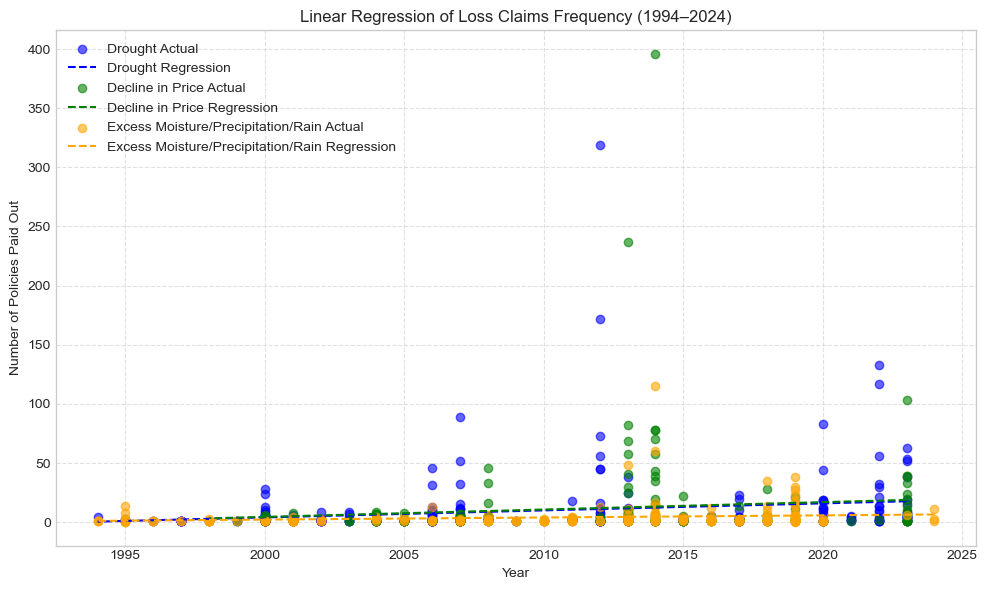

Cause of Loss: Drought
  Regression Equation: y = 0.59x + -1183.41
  R-squared: 0.0348

Cause of Loss: Decline in Price
  Regression Equation: y = 0.62x + -1241.96
  R-squared: 0.0128

Cause of Loss: Excess Moisture/Precipitation/Rain
  Regression Equation: y = 0.18x + -357.05
  R-squared: 0.0202



In [54]:
# Question #16: LINEAR REGRESSION
# Conduct a linear regression on the frequency of loss claims for the top 3 cause of loss claims identified in
# prompt #15 for 1994-2024. Provide the plot (plot all 3 on the same chart), regression equations, and
# correlation coefficients in your response.

# Attempt 1 -- raw data only
# Discard this attempt; try something else

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Prepare data
df = cause_of_loss_smith_co.copy()
df["# of Policies Paid Out"] = pd.to_numeric(df["# of Policies Paid Out"], errors="coerce").fillna(0)
# Identify top 3 causes of loss by total policies paid out
top3_causes = (
    df.groupby("Cause of Loss")["# of Policies Paid Out"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .index
    .tolist()
)

# show the causes of loss in a table
print(df.groupby("Cause of Loss")["# of Policies Paid Out"].sum().sort_values(ascending=False).head(3))

# Set up plot
plt.figure(figsize=(10,6))
colors = ["blue", "green", "orange"]
results = []
# Perform regression for each top cause
for i, cause in enumerate(top3_causes):
    cause_data = df[df["Cause of Loss"] == cause]
    X = cause_data[["Year"]].values
    y = cause_data["# of Policies Paid Out"].values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r_squared = model.score(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    results.append((cause, slope, intercept, r_squared))
    # Plot actual data
    plt.scatter(X, y, color=colors[i], label=f"{cause} Actual", alpha=0.6)
    # Plot regression line
    plt.plot(X, y_pred, color=colors[i], linestyle="--", label=f"{cause} Regression")
# Finalize plot
plt.title("Linear Regression of Loss Claims Frequency (1994–2024)")
plt.xlabel("Year")
plt.ylabel("Number of Policies Paid Out")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
# Display regression results
for cause, slope, intercept, r_squared in results:
    print(f"Cause of Loss: {cause}")
    print(f"  Regression Equation: y = {slope:.2f}x + {intercept:.2f}")
    print(f"  R-squared: {r_squared:.4f}\n")
# Linear regression on frequency of loss claims for top 3 causes of loss (1994–2024)


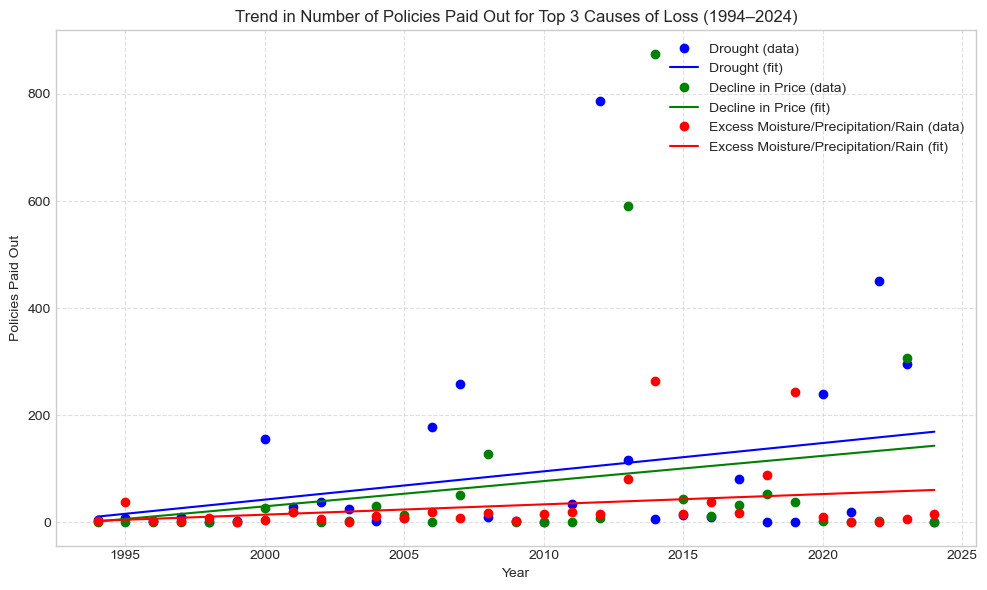

,Cause of Loss,Equation,R²,Correlation
0,Drought,y = 5.29x + -10533.69,0.080,0.283
1,Decline in Price,y = 4.72x + -9401.05,0.051,0.227
2,Excess Moisture/Precipitation/Rain,y = 1.92x + -3832.73,0.077,0.278


In [55]:
# Q16 continued
# Now try with aggregated data


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Prepare data
df = cause_of_loss_smith_co.copy()
df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")
df["# of Policies Paid Out"] = pd.to_numeric(df["# of Policies Paid Out"], errors="coerce").fillna(0)
df = df[(df["Year"] >= 1994) & (df["Year"] <= 2024)]

# Aggregate policies paid out per year and cause
yearly = (
    df.groupby(["Year", "Cause of Loss"])["# of Policies Paid Out"]
    .sum()
    .reset_index()
)

# Top 3 causes overall
top3_causes = (
    df.groupby("Cause of Loss")["# of Policies Paid Out"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .index.tolist()
)

# Run regressions and plot
plt.figure(figsize=(10,6))
colors = ["blue", "green", "red"]
reg_results = []

for cause, color in zip(top3_causes, colors):
    # Reindex to include all years 1994-2024 with zero for missing combinations
    subset = yearly[yearly["Cause of Loss"] == cause].set_index("Year")
    subset = subset.reindex(range(1994, 2025), fill_value=0)["# of Policies Paid Out"].reset_index()
    subset.columns = ["Year", "# of Policies Paid Out"]
    subset = subset.sort_values("Year")
    X = subset["Year"].values.reshape(-1, 1)
    y = subset["# of Policies Paid Out"].values

    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = r2_score(y, y_pred)
    corr = np.corrcoef(subset["Year"], subset["# of Policies Paid Out"])[0,1]
    
    reg_results.append({
        "Cause of Loss": cause,
        "Equation": f"y = {slope:.2f}x + {intercept:.2f}",
        "R²": round(r2, 3),
        "Correlation": round(corr, 3)
    })
    
    plt.plot(subset["Year"], y, "o", color=color, label=f"{cause} (data)")
    plt.plot(subset["Year"], y_pred, "-", color=color, label=f"{cause} (fit)")

plt.title("Trend in Number of Policies Paid Out for Top 3 Causes of Loss (1994–2024)")
plt.xlabel("Year")
plt.ylabel("Policies Paid Out")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Display regression equations and correlation coefficients
results_df = pd.DataFrame(reg_results)
display(results_df)

=== TABLE 1: Full Diagnostic (OLS & Robust × Full and Recent Windows) ===


,Cause of Loss,Window,Fit,Equation (centered at window start),Slope/Decade,R²,Correlation
0,Drought,1994-2024,OLS,y = 5.29*(Year - 1994) + 10.39,52.9,0.080,0.283
1,Drought,1994-2024,Robust,y = 0.94*(Year - 1994) + 2.89,9.4,-0.163,0.283
2,Drought,2008-2024,OLS,y = 5.22*(Year - 2008) + 79.57,52.2,0.015,0.123
3,Drought,2008-2024,Robust,y = 2.44*(Year - 2008) + 3.44,24.4,-0.212,0.123
4,Decline in Price,1994-2024,OLS,y = 4.72*(Year - 1994) + 1.30,47.2,0.051,0.227
5,Decline in Price,1994-2024,Robust,y = 0.27*(Year - 1994) + -0.22,2.7,-0.128,0.227
6,Decline in Price,2008-2024,OLS,y = -5.39*(Year - 2008) + 166.02,-53.9,0.012,-0.110
7,Decline in Price,2008-2024,Robust,y = 0.62*(Year - 2008) + 10.35,6.2,-0.205,-0.110
8,Excess Moisture/Precipitation/Rain,1994-2024,OLS,y = 1.92*(Year - 1994) + 2.50,19.2,0.077,0.278
9,Excess Moisture/Precipitation/Rain,1994-2024,Robust,y = 0.50*(Year - 1994) + 2.55,5.0,-0.084,0.278



=== TABLE 2: Era Shift Comparison (1994–2024 vs 2008–2024) ===


,Cause of Loss,1994–2024 Slope/Decade,2008–2024 Slope/Decade,Slope Change (per decade),% Change,Trend Shift?
0,Drought,52.9,52.2,-0.7,-1.3%,YES - Decelerating
1,Decline in Price,47.2,-53.9,-101.1,-214.2%,YES - Decelerating
2,Excess Moisture/Precipitation/Rain,19.2,-1.5,-20.7,-107.8%,YES - Decelerating


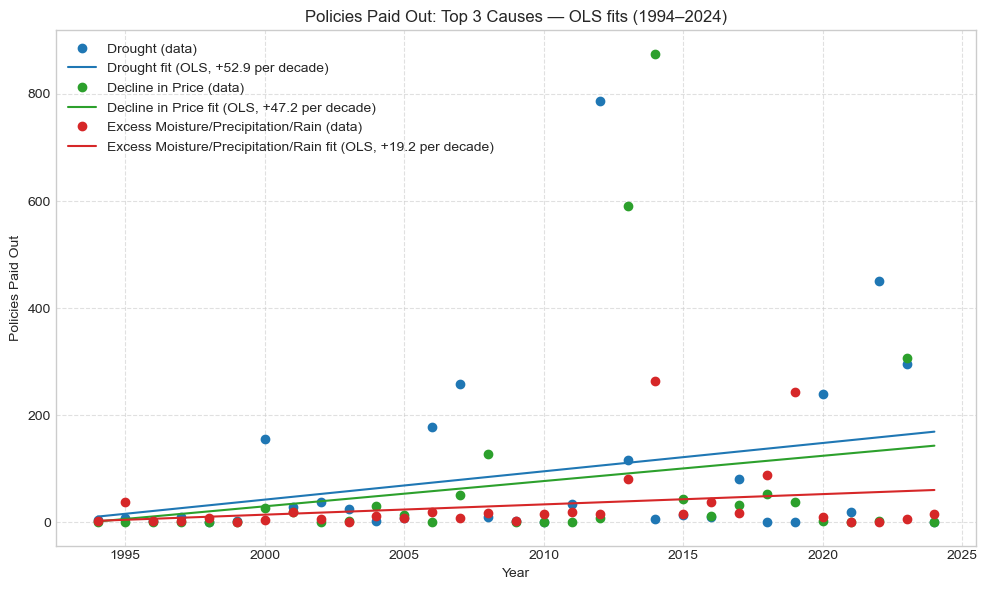

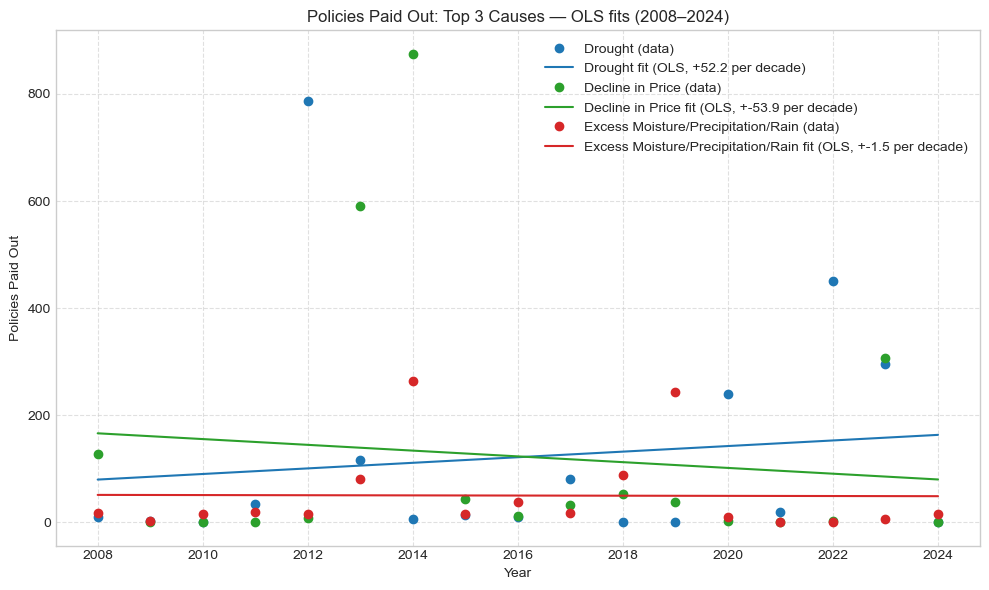

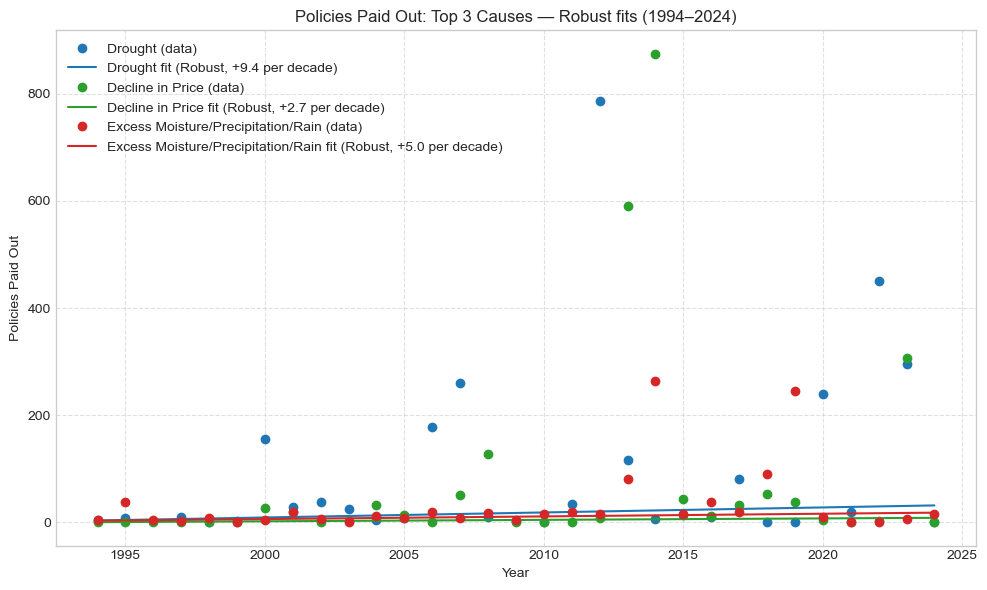

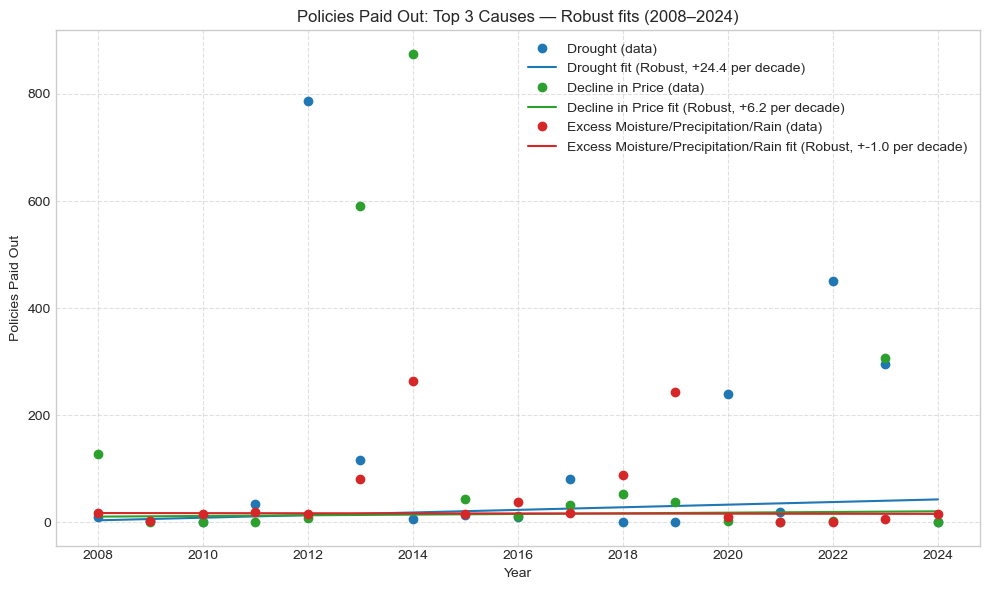

In [56]:
# The prior equation looks good but we can try something better
# Refit with centered year and a robust fit
# Also compare early vs recent periods to detect shifts around 2008
# FINAL OUTPUT - use this in the answer! 

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.metrics import r2_score

# Prep yearly counts
df = cause_of_loss_smith_co.copy()
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["# of Policies Paid Out"] = pd.to_numeric(df["# of Policies Paid Out"], errors="coerce").fillna(0)
yearly_raw = (
    df[(df["Year"]>=1994)&(df["Year"]<=2024)]
    .groupby(["Year","Cause of Loss"])["# of Policies Paid Out"]
    .sum()
    .reset_index()
)

# Top 3 causes overall
top3 = (
    yearly_raw.groupby("Cause of Loss")["# of Policies Paid Out"]
    .sum().sort_values(ascending=False).head(3).index.tolist()
)

# Reindex yearly data to include all years for all causes (missing = 0)
yearly = []
for cause in top3:
    cause_data = yearly_raw[yearly_raw["Cause of Loss"] == cause].set_index("Year")
    cause_data = cause_data.reindex(range(1994, 2025), fill_value=0)
    cause_data["Cause of Loss"] = cause
    yearly.append(cause_data.reset_index())
yearly = pd.concat(yearly, ignore_index=True)

def fit_and_summarize(sub, cause, start=1994, end=2024, robust=False):
    z = sub[(sub["Year"]>=start)&(sub["Year"]<=end)&(sub["Cause of Loss"]==cause)].sort_values("Year")
    X = (z["Year"] - z["Year"].min()).values.reshape(-1,1)  # centered within window
    y = z["# of Policies Paid Out"].values
    model = (TheilSenRegressor() if robust else LinearRegression()).fit(X, y)
    y_hat = model.predict(X)
    slope = float(model.coef_[0])                 # policies per year
    intercept = float(model.intercept_)           # at first year of window
    r2 = r2_score(y, y_hat)
    corr = np.corrcoef(X.ravel(), y)[0,1]
    return {
        "cause": cause,
        "window": f"{start}-{end}",
        "fit": "Robust" if robust else "OLS",
        "slope_per_year": round(slope, 2),
        "slope_per_decade": round(10*slope, 1),
        "intercept_at_start": round(intercept, 2),
        "R2": round(r2, 3),
        "corr": round(corr, 3),
        "years": z["Year"].values,
        "y": y,
        "y_hat": y_hat,
    }

results = []
for c in top3:
    results.append(fit_and_summarize(yearly, c, 1994, 2024, robust=False))
    results.append(fit_and_summarize(yearly, c, 1994, 2024, robust=True))
    results.append(fit_and_summarize(yearly, c, 2008, 2024, robust=False))
    results.append(fit_and_summarize(yearly, c, 2008, 2024, robust=True))

# Table 1: Full diagnostic with all 4 fits per cause (OLS & Robust × 2 windows)
print("=== TABLE 1: Full Diagnostic (OLS & Robust × Full and Recent Windows) ===")
out = pd.DataFrame([{
    "Cause of Loss": r["cause"],
    "Window": r["window"],
    "Fit": r["fit"],
    "Equation (centered at window start)": f"y = {r['slope_per_year']:.2f}*(Year - {r['window'].split('-')[0]}) + {r['intercept_at_start']:.2f}",
    "Slope/Decade": r["slope_per_decade"],
    "R²": r["R2"],
    "Correlation": r["corr"],
} for r in results])
display(out)

# Table 2: Era shift comparison (1994-2024 vs 2008-2024 OLS only)
print("\n=== TABLE 2: Era Shift Comparison (1994–2024 vs 2008–2024) ===")
comparison_rows = []
for c in top3:
    early = [x for x in results if x["cause"]==c and x["window"]=="1994-2024" and x["fit"]=="OLS"][0]
    recent = [x for x in results if x["cause"]==c and x["window"]=="2008-2024" and x["fit"]=="OLS"][0]
    
    slope_diff = recent["slope_per_year"] - early["slope_per_year"]
    slope_diff_pct = 100 * slope_diff / early["slope_per_year"] if early["slope_per_year"] != 0 else 0
    
    comparison_rows.append({
        "Cause of Loss": c,
        "1994–2024 Slope/Decade": early["slope_per_decade"],
        "2008–2024 Slope/Decade": recent["slope_per_decade"],
        "Slope Change (per decade)": round(10*slope_diff, 1),
        "% Change": f"{slope_diff_pct:+.1f}%",
        "Trend Shift?": "YES - Accelerating" if slope_diff > 0 else "YES - Decelerating" if slope_diff < 0 else "NO",
    })

comparison_df = pd.DataFrame(comparison_rows)
display(comparison_df)

# Plot 1: OLS fits for full window (1994–2024) with clearer interpretation
plt.figure(figsize=(10,6))
colors = ["C0","C2","C3"]  # default color cycle
for i, c in enumerate(top3):
    r = [x for x in results if x["cause"]==c and x["window"]=="1994-2024" and x["fit"]=="OLS"][0]
    plt.plot(r["years"], r["y"], "o", color=colors[i], label=f"{c} (data)")
    # extend fit across full window
    yr0 = r["years"].min()
    xx = np.arange(1994, 2025)
    yy = r["intercept_at_start"] + r["slope_per_year"]*(xx - yr0)
    plt.plot(xx, yy, "-", color=colors[i], label=f"{c} fit (OLS, +{r['slope_per_decade']} per decade)")

plt.title("Policies Paid Out: Top 3 Causes — OLS fits (1994–2024)")
plt.xlabel("Year")
plt.ylabel("Policies Paid Out")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: OLS fits for recent window (2008–2024) with clearer interpretation
plt.figure(figsize=(10,6))
colors = ["C0","C2","C3"]  # default color cycle
for i, c in enumerate(top3):
    r = [x for x in results if x["cause"]==c and x["window"]=="2008-2024" and x["fit"]=="OLS"][0]
    plt.plot(r["years"], r["y"], "o", color=colors[i], label=f"{c} (data)")
    # extend fit across the 2008–2024 window
    yr0 = r["years"].min()
    xx = np.arange(2008, 2025)
    yy = r["intercept_at_start"] + r["slope_per_year"]*(xx - yr0)
    plt.plot(xx, yy, "-", color=colors[i], label=f"{c} fit (OLS, +{r['slope_per_decade']} per decade)")

plt.title("Policies Paid Out: Top 3 Causes — OLS fits (2008–2024)")
plt.xlabel("Year")
plt.ylabel("Policies Paid Out")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: Robust (Theil-Sen) fits for full window (1994–2024)
plt.figure(figsize=(10,6))
colors = ["C0","C2","C3"]  # default color cycle
for i, c in enumerate(top3):
    r = [x for x in results if x["cause"]==c and x["window"]=="1994-2024" and x["fit"]=="Robust"][0]
    plt.plot(r["years"], r["y"], "o", color=colors[i], label=f"{c} (data)")
    # extend fit across full window
    yr0 = r["years"].min()
    xx = np.arange(1994, 2025)
    yy = r["intercept_at_start"] + r["slope_per_year"]*(xx - yr0)
    plt.plot(xx, yy, "-", color=colors[i], label=f"{c} fit (Robust, +{r['slope_per_decade']} per decade)")

plt.title("Policies Paid Out: Top 3 Causes — Robust fits (1994–2024)")
plt.xlabel("Year")
plt.ylabel("Policies Paid Out")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 4: Robust (Theil-Sen) fits for recent window (2008–2024)
plt.figure(figsize=(10,6))
colors = ["C0","C2","C3"]  # default color cycle
for i, c in enumerate(top3):
    r = [x for x in results if x["cause"]==c and x["window"]=="2008-2024" and x["fit"]=="Robust"][0]
    plt.plot(r["years"], r["y"], "o", color=colors[i], label=f"{c} (data)")
    # extend fit across the 2008–2024 window
    yr0 = r["years"].min()
    xx = np.arange(2008, 2025)
    yy = r["intercept_at_start"] + r["slope_per_year"]*(xx - yr0)
    plt.plot(xx, yy, "-", color=colors[i], label=f"{c} fit (Robust, +{r['slope_per_decade']} per decade)")

plt.title("Policies Paid Out: Top 3 Causes — Robust fits (2008–2024)")
plt.xlabel("Year")
plt.ylabel("Policies Paid Out")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

=== TABLE: Weighted Least Squares with Exponential Time-Decay (decay_rate=0.1) ===
(Recent years weighted higher; older years downweighted exponentially)


,Cause of Loss,Window,Equation (centered at window start),Slope/Decade,R²,Correlation
0,Drought,1994-2024,y = 5.00*(Year - 1994) + 15.30,50.0,0.038,0.196
1,Drought,2008-2024,y = 5.96*(Year - 2008) + 72.69,59.6,0.020,0.140
2,Decline in Price,1994-2024,y = 0.85*(Year - 1994) + 74.73,8.5,0.001,0.031
3,Decline in Price,2008-2024,y = -8.19*(Year - 2008) + 191.15,-81.9,0.031,-0.175
4,Excess Moisture/Precipitation/Rain,1994-2024,y = 0.37*(Year - 1994) + 32.70,3.7,0.001,0.037
5,Excess Moisture/Precipitation/Rain,2008-2024,y = -3.09*(Year - 2008) + 77.91,-30.9,0.033,-0.183


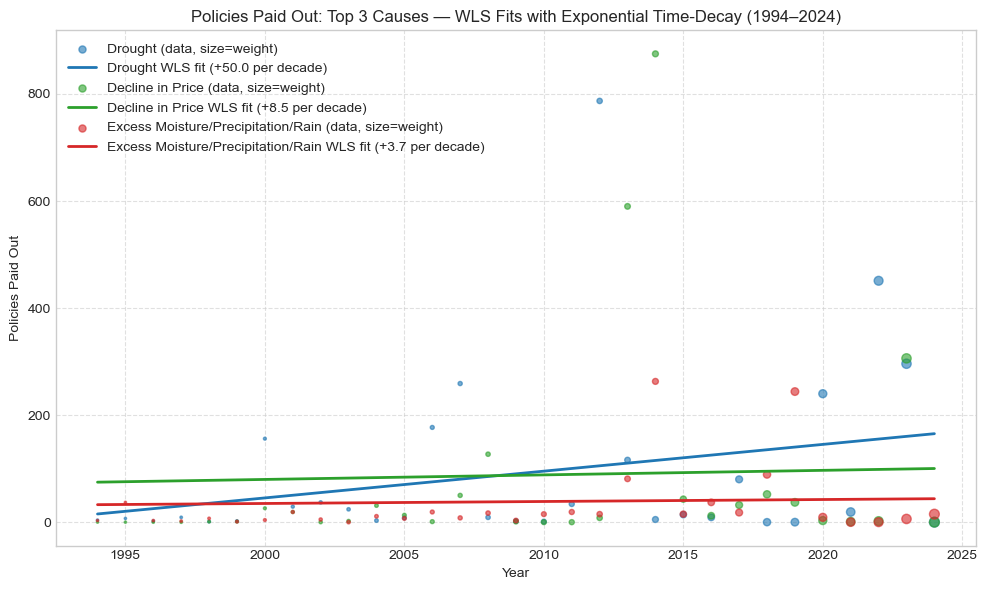

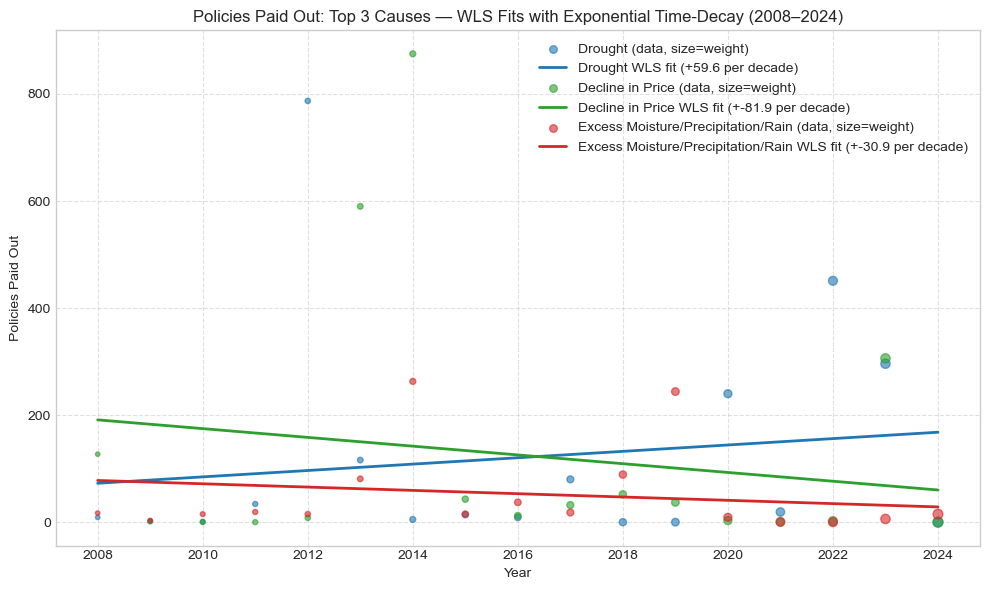


Note: Data points are sized by their weight in the fit.
Recent years appear larger (higher weight); older years appear smaller (lower weight).


In [58]:
# Q16 continued - Weighted Least Squares (WLS) with exponential time-decay weighting
# Recent data prioritized as more relevant for climate/insurance trend forecasting
# Uses centered year for interpretability (consistent with cell 18)

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Prep yearly counts
df = cause_of_loss_smith_co.copy()
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["# of Policies Paid Out"] = pd.to_numeric(df["# of Policies Paid Out"], errors="coerce").fillna(0)
yearly_raw = (
    df[(df["Year"]>=1994)&(df["Year"]<=2024)]
    .groupby(["Year","Cause of Loss"])["# of Policies Paid Out"]
    .sum()
    .reset_index()
)

# Top 3 causes overall
top3 = (
    yearly_raw.groupby("Cause of Loss")["# of Policies Paid Out"]
    .sum().sort_values(ascending=False).head(3).index.tolist()
)

# Reindex yearly data to include all years for all causes (missing = 0)
yearly = []
for cause in top3:
    cause_data = yearly_raw[yearly_raw["Cause of Loss"] == cause].set_index("Year")
    cause_data = cause_data.reindex(range(1994, 2025), fill_value=0)
    cause_data["Cause of Loss"] = cause
    yearly.append(cause_data.reset_index())
yearly = pd.concat(yearly, ignore_index=True)

def fit_wls_exponential_decay(sub, cause, start=1994, end=2024, decay_rate=0.1):
    """
    Fit WLS with exponential time-decay weighting using centered year.
    decay_rate: higher values = faster decay of old data
    Recent years get weight ~1.0, old years get weight < 1.0
    """
    z = sub[(sub["Year"]>=start)&(sub["Year"]<=end)&(sub["Cause of Loss"]==cause)].sort_values("Year")
    X = (z["Year"] - z["Year"].min()).values.reshape(-1,1)  # centered within window
    y = z["# of Policies Paid Out"].values
    
    # Compute exponential decay weights based on age
    max_year = z["Year"].max()
    age = max_year - z["Year"].values  # years from most recent
    weights = np.exp(-decay_rate * age)  # exponential decay: recent=1.0, old=lower
    
    # Fit WLS
    model = LinearRegression()
    model.fit(X, y, sample_weight=weights)
    y_hat = model.predict(X)
    
    slope = float(model.coef_[0])
    intercept = float(model.intercept_)
    # For WLS, R² can be computed on residuals
    residuals = y - y_hat
    ss_res = np.sum(weights * residuals**2)
    ss_tot = np.sum(weights * (y - np.average(y, weights=weights))**2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    # Correlation (weighted)
    weighted_mean_x = np.average(X.ravel(), weights=weights)
    weighted_mean_y = np.average(y, weights=weights)
    num = np.sum(weights * (X.ravel() - weighted_mean_x) * (y - weighted_mean_y))
    denom = np.sqrt(np.sum(weights * (X.ravel() - weighted_mean_x)**2) * np.sum(weights * (y - weighted_mean_y)**2))
    corr = num / denom if denom > 0 else 0
    
    return {
        "cause": cause,
        "window": f"{start}-{end}",
        "fit": "WLS (exponential decay)",
        "slope_per_year": round(slope, 2),
        "slope_per_decade": round(10*slope, 1),
        "intercept_at_start": round(intercept, 2),
        "R2": round(r2, 3),
        "corr": round(corr, 3),
        "years": z["Year"].values,
        "y": y,
        "y_hat": y_hat,
        "weights": weights,
    }

# Fit WLS models for both windows with exponential decay
results_wls = []
for c in top3:
    results_wls.append(fit_wls_exponential_decay(yearly, c, 1994, 2024, decay_rate=0.1))
    results_wls.append(fit_wls_exponential_decay(yearly, c, 2008, 2024, decay_rate=0.1))

# Table: WLS results with exponential time-decay weighting (centered year)
print("=== TABLE: Weighted Least Squares with Exponential Time-Decay (decay_rate=0.1) ===")
print("(Recent years weighted higher; older years downweighted exponentially)")
wls_out = pd.DataFrame([{
    "Cause of Loss": r["cause"],
    "Window": r["window"],
    "Equation (centered at window start)": f"y = {r['slope_per_year']:.2f}*(Year - {r['window'].split('-')[0]}) + {r['intercept_at_start']:.2f}",
    "Slope/Decade": r["slope_per_decade"],
    "R²": r["R2"],
    "Correlation": r["corr"],
} for r in results_wls])
display(wls_out)

# Plot: WLS fits for full window (1994–2024)
plt.figure(figsize=(10,6))
colors = ["C0","C2","C3"]
for i, c in enumerate(top3):
    r = [x for x in results_wls if x["cause"]==c and x["window"]=="1994-2024"][0]
    # Plot data points sized by weight
    plt.scatter(r["years"], r["y"], s=50*r["weights"], color=colors[i], alpha=0.6, 
                label=f"{c} (data, size=weight)")
    # Plot WLS fit line (centered year)
    yr0 = r["years"].min()
    xx = np.arange(1994, 2025)
    yy = r["intercept_at_start"] + r["slope_per_year"]*(xx - yr0)
    plt.plot(xx, yy, "-", color=colors[i], linewidth=2,
             label=f"{c} WLS fit (+{r['slope_per_decade']} per decade)")

plt.title("Policies Paid Out: Top 3 Causes — WLS Fits with Exponential Time-Decay (1994–2024)")
plt.xlabel("Year")
plt.ylabel("Policies Paid Out")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Plot: WLS fits for recent window (2008–2024)
plt.figure(figsize=(10,6))
colors = ["C0","C2","C3"]
for i, c in enumerate(top3):
    r = [x for x in results_wls if x["cause"]==c and x["window"]=="2008-2024"][0]
    # Plot data points sized by weight
    plt.scatter(r["years"], r["y"], s=50*r["weights"], color=colors[i], alpha=0.6,
                label=f"{c} (data, size=weight)")
    # Plot WLS fit line (centered year)
    yr0 = r["years"].min()
    xx = np.arange(2008, 2025)
    yy = r["intercept_at_start"] + r["slope_per_year"]*(xx - yr0)
    plt.plot(xx, yy, "-", color=colors[i], linewidth=2,
             label=f"{c} WLS fit (+{r['slope_per_decade']} per decade)")

plt.title("Policies Paid Out: Top 3 Causes — WLS Fits with Exponential Time-Decay (2008–2024)")
plt.xlabel("Year")
plt.ylabel("Policies Paid Out")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print("\nNote: Data points are sized by their weight in the fit.")
print("Recent years appear larger (higher weight); older years appear smaller (lower weight).")

In [20]:
# Question #17: CAUSE OF LOSS TRENDS OR PATTERNS
# Referring to your regression conducted above in #16, describe 2-3 trends or patterns you observe in causes
# of loss over the historical timeframe (e.g., maximums, minimums, patterns, co-occurrence of causes of loss,
# etc.). Offer a short plausible explanation for why you believe the trend occurs (1-2 sentences each).

# Maximum and minumums for each 
for cause in top3:
    subset = yearly[yearly["Cause of Loss"] == cause]
    max_year = subset.loc[subset["# of Policies Paid Out"].idxmax()]
    min_year = subset.loc[subset["# of Policies Paid Out"].idxmin()]
    print(f"Cause of Loss: {cause}")
    print(f"  Maximum Policies Paid Out: {max_year['# of Policies Paid Out']} in {int(max_year['Year'])}")
    print(f"  Minimum Policies Paid Out: {min_year['# of Policies Paid Out']} in {int(min_year['Year'])}\n")

    # Maximum and minimiums based on $ total paid out; be careful of data types 
    df["Avg amout paid out per policy"] = pd.to_numeric(df["Avg amout paid out per policy"], errors="coerce").fillna(0)
    df["Total Paid Out"] = df["# of Policies Paid Out"] * df["Avg amout paid out per policy"]
    subset_dollar = df[df["Cause of Loss"] == cause]
    max_year_dollar = subset_dollar.loc[subset_dollar["Total Paid Out"].idxmax()]
    min_year_dollar = subset_dollar.loc[subset_dollar["Total Paid Out"].idxmin()]
    print(f"  Maximum $ Paid Out: ${max_year_dollar['Total Paid Out']:,.2f} in {int(max_year_dollar['Year'])}")
    print(f"  Minimum $ Paid Out: ${min_year_dollar['Total Paid Out']:,.2f} in {int(min_year_dollar['Year'])}\n")
    

Cause of Loss: Drought
  Maximum Policies Paid Out: 787 in 2012
  Minimum Policies Paid Out: 1 in 1998

  Maximum $ Paid Out: $12,816,085.30 in 2012
  Minimum $ Paid Out: $-26,359.00 in 2012

Cause of Loss: Decline in Price
  Maximum Policies Paid Out: 875 in 2014
  Minimum Policies Paid Out: 1 in 1998

  Maximum $ Paid Out: $5,023,494.27 in 2014
  Minimum $ Paid Out: $-12,774.00 in 2020

Cause of Loss: Excess Moisture/Precipitation/Rain
  Maximum Policies Paid Out: 263 in 2014
  Minimum Policies Paid Out: 1 in 1999

  Maximum $ Paid Out: $1,938,965.60 in 2014
  Minimum $ Paid Out: $-39,296.00 in 2018



In [21]:
# Question #18: ASSUMPTION EVALUATION
# In 1-2 sentences, evaluate and assess the reasonableness and rational basis for the assumption below. Note
# why the assumption is necessary or reasonable to simplify the topic in order to model or if the assumption
# goes beyond what is reasonable.

# Assumption:
# “Nationally, approximately 91% of farm producers have farm insurance. We assume that the rate of
#farm producers who have farm insurance is the same for Smith County, Iowa.”

In [22]:
# Question #19: ASSUMPTION DEVELOPMENT
# Write your own 1-2 sentence assumption that would pertain to this real-world scenario for math model
# creation (it may be an assumption about the scenario’s data, problem statement, possible outcomes, math
# model structure, or other pertinent factor). Provide a 1-2 sentence justification explanation as to why the
# assumption is needed and reasonable.


Unique causes of loss:
['Hail' 'Excess Moisture/Precipitation/Rain' 'Cold Wet Weather' 'Flood'
 'Decline in Price' 'Drought' 'Heat'
 'ARPI/SCO/ECO/STAX/MP/HIP-WI/PACE Crops Only' 'Insects' 'Plant Disease'
 'Other (Snow, Lightning, Etc.)' 'Failure of Irrigation Supply' 'Hot Wind'
 'Wind/Excess Wind' 'ARPI/SCO/STAX/MP Crops Only'
 'Federal or State Ordered Destruction' 'All Other Causes' 'Frost'
 'ARPI Crops Only' 'GRP/Grip Crops' nan 'Mycotoxin'
 'Mycotoxin (Aflatoxin)' 'Other (Snow,Lightning,etc)'
 'GRP/GRIP Crops Only`' 'Cyclone' 'Failure Of Irrigation Supply' 'Freeze'
 'Cold Winter' 'Wildlife' 'Other (Volcano,Snow,Lightning,etc)']

Drought claims by year (1994-2024):
Year
1994      4
1995      7
1996      2
1997      9
1998      1
1999      2
2000    156
2001     29
2002     37
2003     24
2004      3
2005      8
2006    177
2007    259
2008      9
2009      2
2010      1
2011     34
2012    787
2013    116
2014      5
2015     14
2016      9
2017     80
2018      0
2019      0
2020 

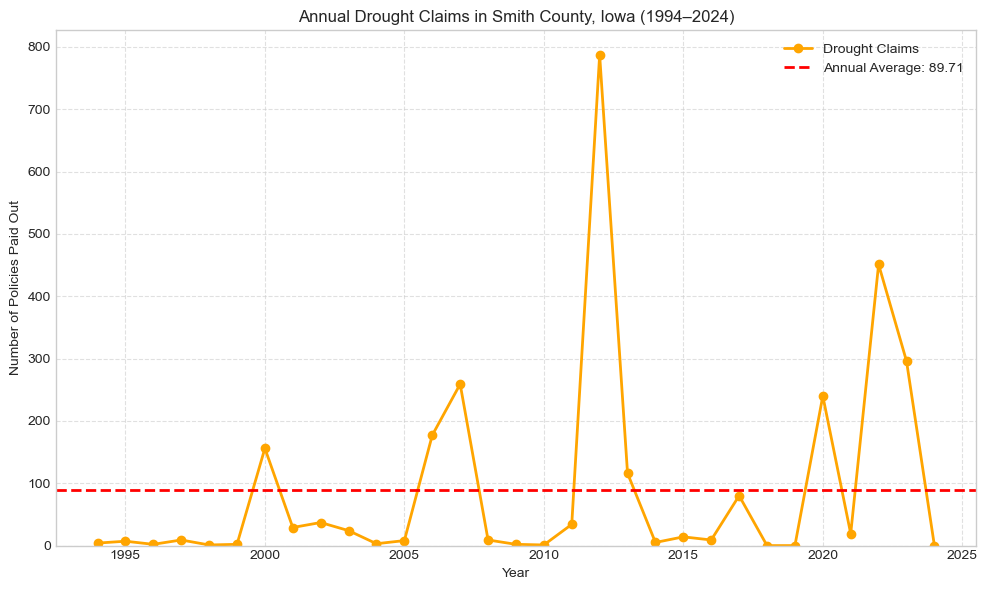

In [45]:
# Question #20: FREQUENCY OF CLAIMS DUE TO DROUGHT
# From the Cause of Loss tab (1994-2024), what is the annual average frequency of claims made for drought
#for farmers in Smith County, Iowa?

# First check unique cause names to ensure correct filtering
print("Unique causes of loss:")
print(cause_of_loss_smith_co["Cause of Loss"].unique())
print()

# Prepare data properly
df_drought = cause_of_loss_smith_co.copy()
df_drought["Year"] = pd.to_numeric(df_drought["Year"], errors="coerce")
df_drought["# of Policies Paid Out"] = pd.to_numeric(df_drought["# of Policies Paid Out"], errors="coerce").fillna(0)

# Filter for drought and aggregate by year
drought_claims = (
    df_drought[(df_drought["Cause of Loss"] == "Drought") & (df_drought["Year"].notna())]
    .groupby("Year")["# of Policies Paid Out"]
    .sum()
    .sort_index()
)

# Reindex to include ALL years 1994-2024, filling missing years with 0
drought_claims = drought_claims.reindex(range(1994, 2025), fill_value=0)

print(f"Drought claims by year (1994-2024):")
print(drought_claims)
print()

annual_average_frequency = drought_claims.mean()
print(f"Annual average frequency of drought claims: {annual_average_frequency:.2f}")    

# Total drought claims over the period
total_drought_claims = drought_claims.sum()
print(f"Total drought claims from 1994-2024: {int(total_drought_claims)}")

# Plot drought claims over time and average line
plt.figure(figsize=(10,6))
plt.plot(drought_claims.index, drought_claims.values, marker="o", color="orange", linewidth=2, markersize=6, label="Drought Claims")
plt.axhline(annual_average_frequency, color="red", linestyle="--", linewidth=2, label=f"Annual Average: {annual_average_frequency:.2f}")
plt.title("Annual Drought Claims in Smith County, Iowa (1994–2024)")
plt.xlabel("Year")
plt.ylabel("Number of Policies Paid Out")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()


In [46]:
# Question #21: EXPECTED VALUE OF LOSS DUE TO DROUGHT
# For Farmer Jones, what is the expected value of crop loss due to drought in a given year (based only on the
# actual cost for Farmer Jones to plant)? Refer to the planting costs found in #7 for Farmer Jones' severity of loss.

# Expected Value = frequency of loss * severity of loss

severity_of_loss = 189097.95  # actual planting costs from Q7 above


# now frequency of loss
total_number_of_farmers = 2936 # given
pct_farmers_with_insurance = 0.91  # given above
number_of_insured_farmers = total_number_of_farmers * pct_farmers_with_insurance
annual_average_frequency = drought_claims.mean()  # from Q20 above
frequency_of_loss = annual_average_frequency / number_of_insured_farmers

expected_value_drought_loss = frequency_of_loss * severity_of_loss
print(f"Frequency of drought loss for Farmer Jones: {frequency_of_loss:.6f}")
print(f"Severity of drought loss for Farmer Jones: ${severity_of_loss:,.2f}")
print(f"Expected value of crop loss due to drought for Farmer Jones: ${expected_value_drought_loss:,.2f}")



Frequency of drought loss for Farmer Jones: 0.033577
Severity of drought loss for Farmer Jones: $189,097.95
Expected value of crop loss due to drought for Farmer Jones: $6,349.34


In [47]:
# Question #22: AVERAGE ANNUAL INSURANCE PAYOUT DUE TO DROUGHT
# What is the average annual insurance payout per policy for farmers in Smith County due to drought (use the
# Cause of Loss tab)? What could this mean for Farmer Jones as she considers her risks due to drought?
# Explain in 2-3 sentences.

# Prepare data
df = cause_of_loss_smith_co.copy()
df["# of Policies Paid Out"] = pd.to_numeric(df["# of Policies Paid Out"], errors="coerce").fillna(0)
df["Avg amout paid out per policy"] = pd.to_numeric(df["Avg amout paid out per policy"], errors="coerce").fillna(0)
df["Total Paid Out"] = df["# of Policies Paid Out"] * df["Avg amout paid out per policy"]
# Filter for drought
drought_data = df[df["Cause of Loss"] == "Drought"]
# Calculate average annual payout per policy
total_payout = drought_data["Total Paid Out"].sum()
total_policies = drought_data["# of Policies Paid Out"].sum()
average_annual_payout_per_policy = total_payout / total_policies if total_policies > 0 else 0   

# print the total payout and total policies for verification
print(f"Total drought payout (1994-2024): ${total_payout:,.2f}")
print(f"Total drought policies paid out (1994-2024): {total_policies}")

print(f"Average annual insurance payout per policy due to drought: ${average_annual_payout_per_policy:,.2f}")


Total drought payout (1994-2024): $73,450,900.68
Total drought policies paid out (1994-2024): 2781
Average annual insurance payout per policy due to drought: $26,411.69


In [26]:
# Question #23: RISK MITIGATION STRATEGY: GRAIN SILO
# Farmer Jones is considering purchasing and installing a grain silo to store harvested corn for long periods
# of time. She is considering a 100,000 bushel grain storage silo that would cost $250,000 to purchase and
# install (labor included).
# What risk(s) might Farmer Jones mitigate by installing a grain silo? What kind of risk mitigation strategy
# is this (behavior change, modifying the outcomes, insurance)? Explain in 1-2 sentences.
# Identify 2-3 advantages or “pros” of installing a grain silo as a risk mitigation strategy. Explain and justify
# your response in 2-3 sentences (no new computations necessary).
# Identify 2-3 disadvantages or “cons” to installing a grain silo as a risk mitigation strategy. Explain and
# justify your response in 2-3 sentences (no new computations necessary).

In [27]:
# Question #24: RISK MITIGATION STRATEGY: IRRIGATION SYSTEM
# Based on the fact that drought seems to be a major cause of loss, Farmer Jones is exploring the option to
# install an irrigation system for her entire farm. Details for the system she is exploring are included below.
# For this scenario, we assume that she has ample groundwater access for the pumps and does not have to
# purchase water access rights.
# Installation Cost: The system would require pumps and permanent piping, which is anticipated to be
# $1,500 per acre for labor and materials.
# Usage Cost: Once installed, per-acre pumping costs are projected to be $58 per acre for energy usage
# for the season and an additional $30 per acre per season for maintenance and repairs.
# Projected impact: Based on conversations with neighboring farmers who have installed irrigation
# systems on their corn farms also in Smith county, it is projected that Farmer Jones could anticipate a
# yield of 270 bushels of corn per acre by using the irrigation system.
# Questions:
# Identify the installation costs and annual operating costs of the irrigation system for Farmer Jones’ farm.
# What is the anticipated annual corn harvest yield (in bushels) with the irrigation system?
# If Farmer Jones were to sell her entire crop upon harvesting in October, what is the anticipated revenue for
# this anticipated harvest with the irrigation system (use the 2016-2025 average corn sale price for October
# as found above in #10)?

installation_cost_per_acre = 1500
usage_cost_per_acre = 58 + 30  # energy + maintenance
total_installation_cost = installation_cost_per_acre * 345
total_annual_usage_cost = usage_cost_per_acre * 345
anticipated_yield_per_acre = 270
total_anticipated_yield = anticipated_yield_per_acre * 345
current_average_yield_per_acre = 178.5  # from prior data

# print installation cost per acre and usage cost per acre for verification
print(f"Installation cost per acre: ${installation_cost_per_acre}")
print(f"Usage cost per acre: ${usage_cost_per_acre}")

# print the total installation cost and annual operating cost
print(f"Total installation cost of irrigation system: ${total_installation_cost:,.2f}")
print(f"Total annual operating cost of irrigation system: ${total_annual_usage_cost:,.2f}")
print(f"Anticipated annual corn harvest yield with irrigation system: {total_anticipated_yield} bushels")

#average sale price in Ocbtober from #10 is $4.21
anticipated_revenue = total_anticipated_yield * 4.21
print(f"Anticipated revenue from harvest with irrigation system: ${anticipated_revenue:,.2f}")


Installation cost per acre: $1500
Usage cost per acre: $88
Total installation cost of irrigation system: $517,500.00
Total annual operating cost of irrigation system: $30,360.00
Anticipated annual corn harvest yield with irrigation system: 93150 bushels
Anticipated revenue from harvest with irrigation system: $392,161.50


In [28]:
# Question #25 onward...
# The U.S. Department of Agriculture’s Risk Management Agency offers a variety of insurance plans available for
# specific commodities, including corn. Farmer Jones is considering purchasing a Revenue Protection crop
#insurance policy. This type of policy would provide a guarantee against the undesirable outcome in which
#anticipated crop yields are lower than projected (due to natural causes) as well as a guarantee against the
# undesirable outcome in which the sale price at harvest is lower than projected sale price when the policy was
# purchased earlier in the year (thus protecting against a drop in revenue). Several types of insurance policies
# exist and the premium (payments that the farmer would need to make to the insurance company) would be
# cheaper or more expensive depending on what is included in the coverage of the policy.
# Equations
# Guarantee per acre = (projected yield) x (coverage percentage) x (higher of projected or harvest price)
# Actual Revenue per acre = (actual yield) x harvest price
# Insurance Payout (only triggered if the guarantee is greater than the actual) = guarantee per acre – actual
# revenue per acre
# Conditions Farmer Jones is considering for a scenario outlining a decline in price:
# Farmer Jones is considering a policy with 85% coverage that has a premium cost of $25 per acre.
# For the scenario that Farmer Jones is considering:
# the approved yield is the same as the actual yield (computed by you in #6),
# the agreed-upon projected price is $5.20 per bushel of corn, and
# at harvest, the actual price was $4.39 per bushel of corn.

# Question #25 #25: CHARACTERIZING THE CROP INSURANCE SCENARIO
# Using the equations and conditions outlined above:
# Find the revenue “guarantee per acre” with 85% coverage.
# Find the “actual revenue per acre.
# Use the values found above. If the insurance payout is triggered, compute the insurance payout per acre
# and total insurance payout. If the insurance payment is not triggered, explain why not (in 1-2
# sentences).

coverage_percentage = 0.85 #unitless - percentage
projected_price = 5.20 #dollars per bushel
harvest_price = 4.39 # dollars per bushel
approved_yield = 178.5  # bushels per acre, actual yield from #6 above
premium_per_acre = 25 # dollars per acre

# round all nunmbers to two decimal places for currency
guarantee_per_acre = round(approved_yield * coverage_percentage * max(projected_price, harvest_price), 2)
actual_revenue_per_acre = round(approved_yield * harvest_price, 2)
print(f"Guarantee per acre: ${guarantee_per_acre:,.2f}")
print(f"Actual revenue per acre: ${actual_revenue_per_acre:,.2f}")
insurance_payout_per_acre = round(guarantee_per_acre - actual_revenue_per_acre, 2)
if insurance_payout_per_acre > 0:
    total_insurance_payout = round(insurance_payout_per_acre * 345, 2)  # total acres
    print(f"Insurance payout is triggered because the guarantee per acre is greater than the actual revenue per acre.")
    print(f"Insurance payout per acre: ${insurance_payout_per_acre:,.2f}")
    print(f"Total insurance payout for the farm: ${total_insurance_payout:,.2f}")
else:
    print("Insurance payout is not triggered because the actual revenue per acre meets or exceeds the guarantee.")


# A strange discrepancy between human and Python calculations. The notebook rounds 178.5 * 4.39 as 783.61 
# due to some floating point conversion. We’ll leave the discrepancy as-is 
# and take the human calculation here


Guarantee per acre: $788.97
Actual revenue per acre: $783.61
Insurance payout is triggered because the guarantee per acre is greater than the actual revenue per acre.
Insurance payout per acre: $5.36
Total insurance payout for the farm: $1,849.20


In [ ]:
# Question #26: VALUE OF THE INSURANCE POLICY
# While Revenue Protection can address the risk of lower yields than anticipated, Farmer Jones is specifically
# interested in exploring how Revenue Protection can be used to mitigate the risk of a drop in price (if she was
# only interested in mitigating risk of lower yields, she could purchase the cheaper Yield Protection insurance).
# Identify the total cost of the annual premium for Farmer Jones’ farm for the Revenue Protection plan
# outlined above.
# Based on the analysis conducted here on Revenue Protection, would you recommend that Farmer Jones
# purchase revenue protection crop insurance to protect against a drop in price or potentially rely on Yield
# Protection insurance only? Why or why not? Explain in 2-3 sentences (additional computations optional).

premium_per_acre = 25 # dollars per acre
total_premium_cost = premium_per_acre * 345  # total acres
print(f"Total annual premium cost for Revenue Protection insurance: ${total_premium_cost:,.2f}")

# total expected revenue from insurance payout: $1,845.75
# What should the price per acre be to make the insurance worthwhile?
actual_revenue_per_acre = 783.62
required_guarantee_per_acre = actual_revenue_per_acre + premium_per_acre
required_projected_price = required_guarantee_per_acre / (approved_yield * coverage_percentage)
print(f"To make the insurance worthwhile, the projected price would need to be at least: ${required_projected_price:,.2f} per bushel.")


Total annual premium cost for Revenue Protection insurance: $8,625.00
To make the insurance worthwhile, the projected price would need to be at least: $5.33 per bushel.


In [36]:
#27: IRRIGATION SYSTEM IMPACT
# Based on the data available to Farmer Jones, other corn farmers in Smith County who have installed an
# irrigation system like the one she is considering have found that their chance of loss due to drought has
# dropped to 0.2% in any given year.
# If Farmer Jones installs the irrigation system as outlined in Prompt #24 above, what is her expected value of
# loss due to drought (with severity of loss being the cost of planting found in #7)?

new_frequency_of_loss = 0.002  # 0.2% expressed as a decimal
severity_of_loss = 189097.95  # actual planting costs from Q7 above
expected_value_drought_loss_with_irrigation = new_frequency_of_loss * severity_of_loss
print(f"Expected value of crop loss due to drought with irrigation system: ${expected_value_drought_loss_with_irrigation:,.2f}")


Expected value of crop loss due to drought with irrigation system: $378.20


In [51]:
#28: COMPARISON OF EXPECTED VALUE OF LOSS
# Compare the expected value of loss with the irrigation mitigation strategy (what you just found in #27 above)
# to the expected value of loss without mitigation measures that you computed in #21. Is this expected value of
# loss a noteworthy improvement or not? Explain in 1-2 sentences and justify your answer with relevant
# supporting computations.

expected_value_drought_loss_without_irrigation = 6349.34 # from 21 above
expected_value_drought_loss_with_irrigation = 378.20 # from 27 above
improvement = expected_value_drought_loss_without_irrigation - expected_value_drought_loss_with_irrigation
improvement_pct = 100 * improvement / expected_value_drought_loss_without_irrigation
print(f"Improvement in expected value of loss due to drought with irrigation system: ${improvement:,.2f} ({improvement_pct:.2f}%)")
print("This is a noteworthy improvement, as the expected value of loss due to drought decreases significantly with the installation of the irrigation system.") 


Improvement in expected value of loss due to drought with irrigation system: $5,971.14 (94.04%)
This is a noteworthy improvement, as the expected value of loss due to drought decreases significantly with the installation of the irrigation system.


In [42]:
#29: PROFIT TRAJECTORY WITH IRRIGATION
# What is the anticipated profit for the first year after utilizing the described irrigation system (assuming the
# planting costs as found in #7)? What implication does this have for a timeframe projection of profitability with
# an irrigation system? Explain and justify your response in 3-5 sentences with any supporting computations necessary.

anticipated_planting_costs = 189097.95  # from Q7 above
total_annual_usage_cost = 30360  # from Q24 above
anticipated_revenue = 392161.50  # from Q24 above


anticipated_profit_first_year = anticipated_revenue - (anticipated_planting_costs + total_annual_usage_cost)
print(f"Anticipated profit for the first year with irrigation system: ${anticipated_profit_first_year:,.2f}")

actual_profit_without_irrigation = 70164.38
profit_difference = anticipated_profit_first_year - actual_profit_without_irrigation
print(f"Difference in profit compared to not having irrigation: ${profit_difference:,.2f}")

total_installation_cost = 517500  # from Q24 above
payback_period_years = total_installation_cost / (actual_profit_without_irrigation - anticipated_profit_first_year)
print(f"Estimated payback period for the irrigation system: {payback_period_years:.2f} years")
print("This implies that while the irrigation system may lead to higher yields and revenue in the long term, the initial costs result in a loss in the first year. The payback period indicates that it may take several years before the investment in the irrigation system becomes profitable.")

Anticipated profit for the first year with irrigation system: $172,703.55
Difference in profit compared to not having irrigation: $102,539.17
Estimated payback period for the irrigation system: -5.05 years
This implies that while the irrigation system may lead to higher yields and revenue in the long term, the initial costs result in a loss in the first year. The payback period indicates that it may take several years before the investment in the irrigation system becomes profitable.
